# Загрузка данных

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
from datetime import datetime as dt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit

from pmdarima import auto_arima 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error 

In [18]:
# Загрузка данных
df = pd.read_excel('data/train.xlsx', index_col='dt')
df.head()

,Цена на арматуру
dt,
2015-01-05,32900
2015-01-12,32500
2015-01-19,32000
2015-01-26,30700
2015-02-02,30300


In [19]:
df.shape

(400, 1)

In [20]:
# df = np.log(df)

In [21]:
df

,Цена на арматуру
dt,
2015-01-05,32900
2015-01-12,32500
2015-01-19,32000
2015-01-26,30700
2015-02-02,30300
...,...
2022-08-01,47500
2022-08-08,49000
2022-08-15,47500


In [22]:
# Разделение данных
test_size = int(len(df) * 0.2)
train, test = df.iloc[:-test_size], df.iloc[-test_size:]

In [23]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train['Цена на арматуру'])
print(f'p-value: {adf_test[1]}')

p-value: 0.08561658406138378


<Axes: xlabel='dt'>

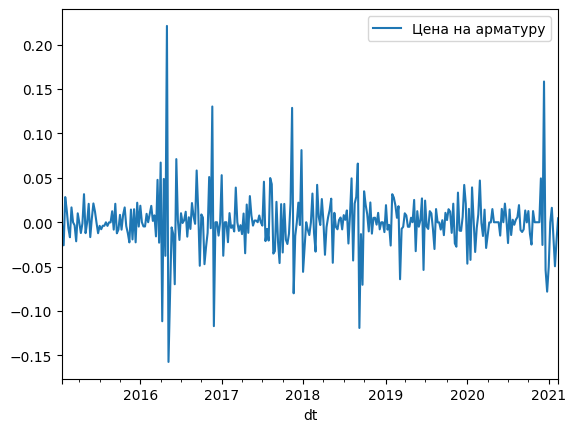

In [24]:
train = np.log(train)
df_train_diff = train.diff().dropna()
df_train_diff = df_train_diff.diff().dropna()
df_train_diff.plot()

In [25]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 3.7472051695177783e-10


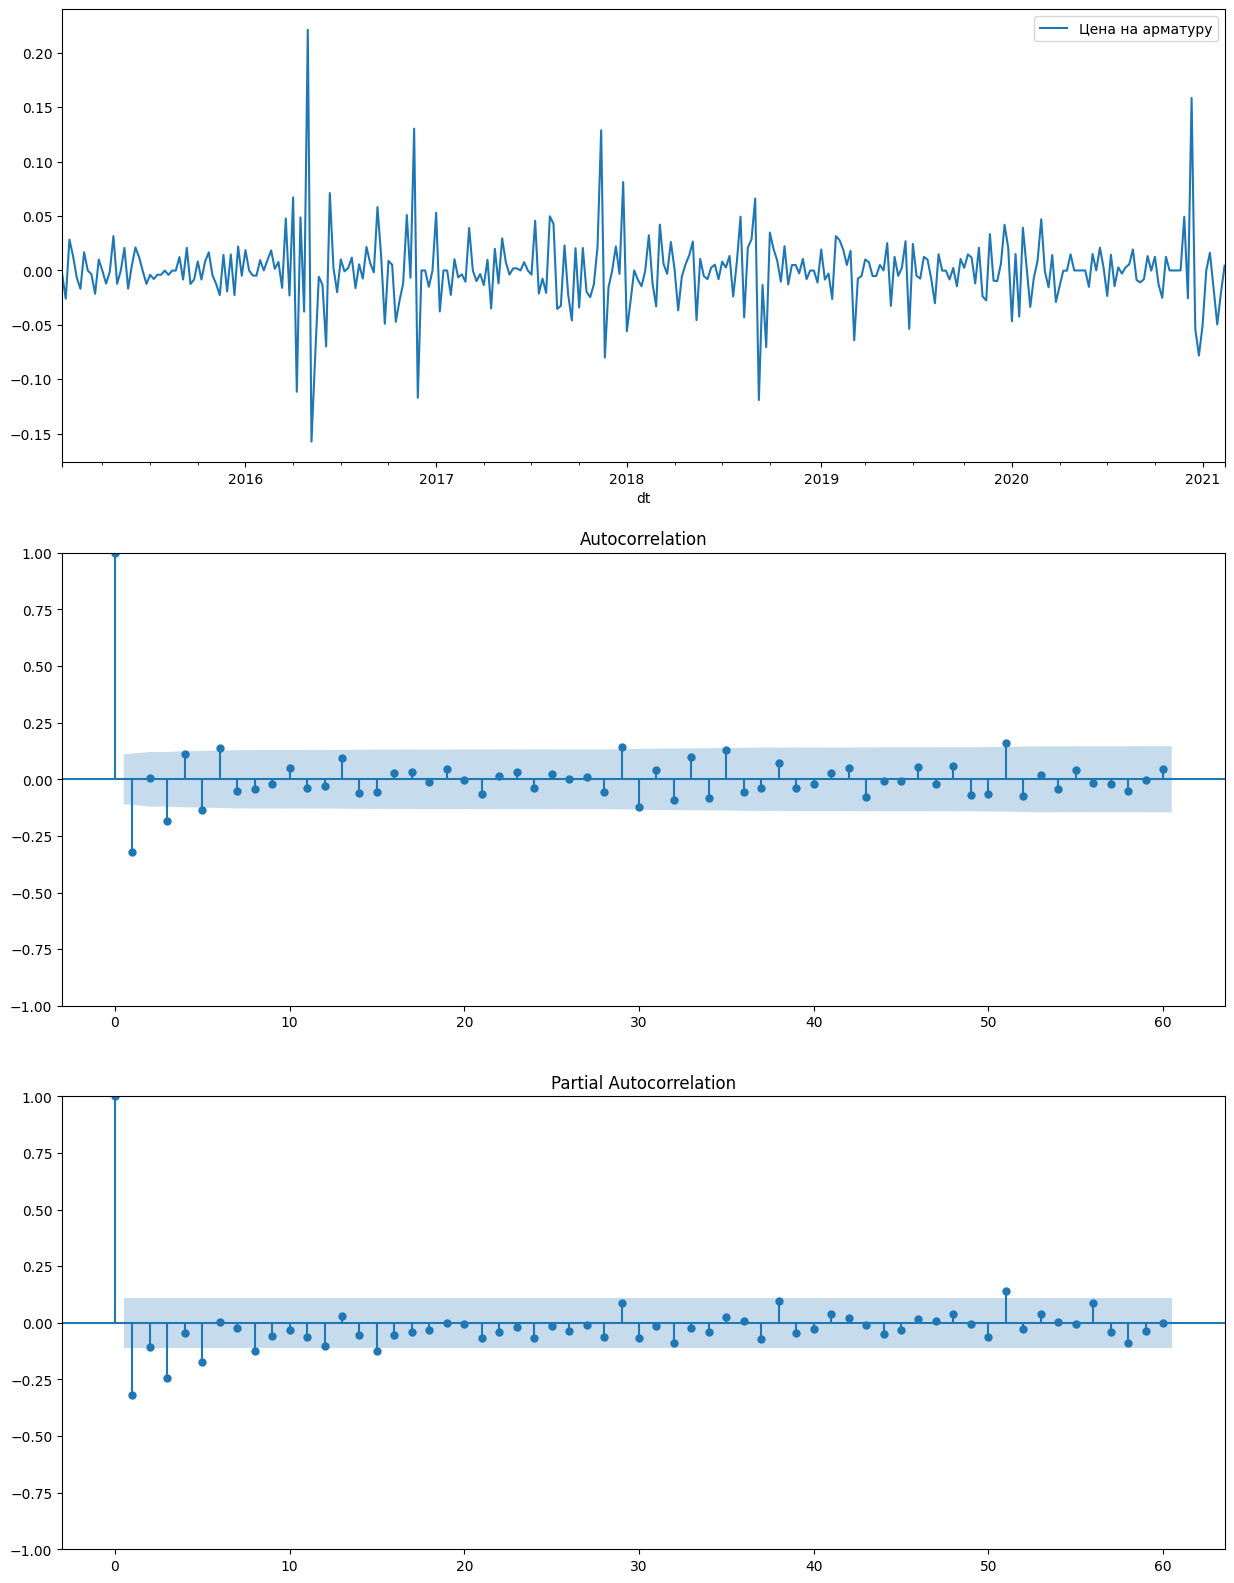

In [26]:
# вывод кореллограмм и ? (аргументировать зачем)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))
df_train_diff.plot(ax=ax[0])
plot_acf(df_train_diff['Цена на арматуру'], lags=60, ax=ax[1])
plot_pacf(df_train_diff['Цена на арматуру'], lags=60, ax=ax[2]);

# Модели

## SARIMAX

In [27]:
# отключаем безвредные предупреждения
warnings.filterwarnings("ignore") 
  
# рассчёт лучших значений для ARIMA 
stepwise_fit = auto_arima(df_train_diff['Цена на арматуру'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=6.38 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-997.056, Time=0.20 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-1109.575, Time=1.76 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-1204.710, Time=1.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-999.051, Time=0.11 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-1048.588, Time=0.56 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-1199.705, Time=2.60 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=7.36 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-1124.968, Time=2.28 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=9.28 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=2.89 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=5.91 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=3.56 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=5.55 sec
 ARIMA(0,0,1)(0,1,1)[12]             : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  318
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 606.355
Date:                            Mon, 24 Mar 2025   AIC                          -1204.710
Time:                                    01:27:16   BIC                          -1189.816
Sample:                                01-19-2015   HQIC                         -1198.754
                                     - 02-15-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -5.744e-05      0.000     -0.313      0.754      -0.000       0.000
ma.L1         -0.5900      0.035    -16.717      0.000      -0.659      -0.521
ma.S.L12      -0.8358      0.063    -13.345      0.000      -0.959      -0.713
sigma2         0.0011   4.86e-05     21.814      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   6.69   Jarque-Bera (JB):               861.55
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             1.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
model = SARIMAX(train, 
				order = (2, 0, 0), 
				seasonal_order =(0, 1, 1, 12)) 

result = model.fit() 
result.summary() 


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     Цена на арматуру   No. Observations:                  320
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 636.592
Date:                              Mon, 24 Mar 2025   AIC                          -1265.184
Time:                                      01:27:18   BIC                          -1250.264
Sample:                                  01-05-2015   HQIC                         -1259.218
                                       - 02-15-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4754      0.043     34.439      0.000       1.391       1.559
ar.L2         -0.4916      0.045    -10.963      0.000      -0.579      -0.404
ma.S.L12      -0.9752      0.089    -10.997      0.000      -1.149      -0.801
sigma2         0.0008   6.63e-05     12.637      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.06   Jarque-Bera (JB):              3153.98
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             2.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='dt'>

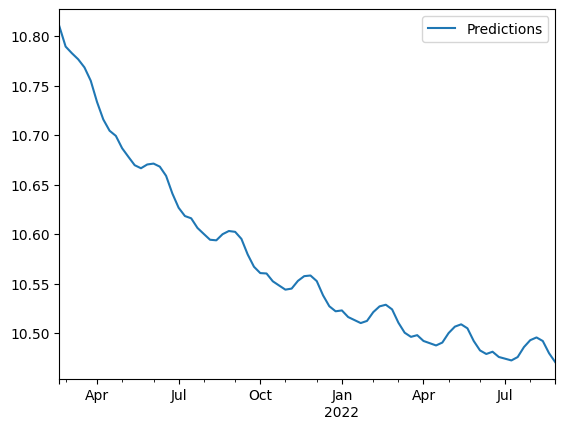

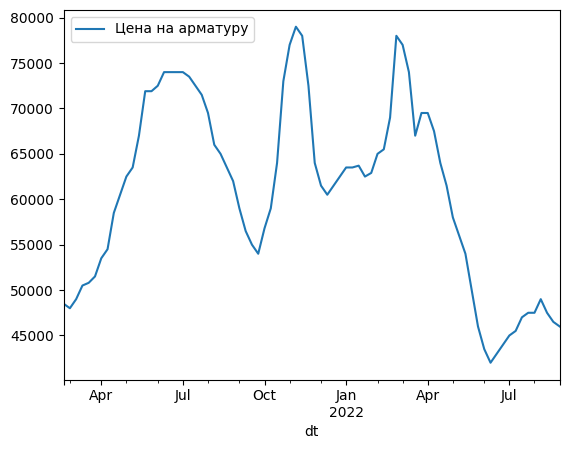

In [ ]:
 
# Predictions for one-year against the test set 
predictions = result.predict( qtyp = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
test.plot(legend = True) 

In [30]:
# Метрики
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)
r2 = r2_score(test, predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 60858.18
MSE: 3808512143.03
MAPE: 1.00%
R²: -35.3426
